# Towards biologically plausible phosphene simulation for the differentiable optimization of visual cortical prostheses

This notebook showcases some of the functionalities and applications of the phosphene simulator 

## 0. Imports

##### Import statements

In [1]:
import os 
import sys
sys.path.append('./..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy

##### Some plotting functions

In [2]:
def plot_fov(params, ax):
    """Plot a polar grid and visualize the field of view of simulation."""
    fov = params['run']['view_angle']
    org = params['run']['origin']

    # Plot the simulation FOV (square)
    x1, x2 = org[0]-fov//2, org[0] + fov//2
    y1, y2 = org[1]-fov//2, org[1] + fov//2
    ax.plot([x1,x1,x2,x2,x1], [y1,y2,y2,y1,y1], color='k')

    # Plot the radial lines
    for angle in np.linspace(-np.pi,np.pi,9) :
        r = []
        phi = []
        for radius in np.linspace(0,60,1000):
            r.append(radius)
            phi.append(angle)

        visual_field = Map(r = np.array(r), phi = np.array(phi))
        ax.plot(*visual_field.cartesian, 'k:',linewidth=.5)


    # Plot the concentric grid lines
    for radius in np.linspace(1,60,8):
        r = []
        phi = []
        for angle in np.linspace(-np.pi,np.pi,100):
            r.append(radius)
            phi.append(angle)

        visual_field = Map(r = np.array(r), phi = np.array(phi))
        ax.plot(*visual_field.cartesian, 'k:',linewidth=.5)
        
    ax.spines[['left', 'bottom']].set_position('center')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set(xticks=[-60,-30, 0,30,60], yticks=[-60,-30, 0,30,60])


def plot_cortex_flatmap(params, ax):
    # Mapping from visual field to cortex (for creating the cortex model grid)
    visual_field_to_cortex = cortex_models.get_mapping_from_visual_field_to_cortex(params['cortex_model'])


    # Plot the radial grid lines    
    for angle in np.linspace(.5*np.pi,1.5*np.pi,6) :
        r = []
        phi = []
        for radius in np.linspace(0,40,1000):
            r.append(radius)
            phi.append(angle)
        
        visual_field = Map(r = np.array(r), phi = np.array(phi))       
        w = visual_field.flip(hor=True, vert=True).complex
        cortex = Map(z=visual_field_to_cortex(w)).flip(hor=False, vert=False)
        ax.plot(*cortex.cartesian, 'k',linewidth=.5)
        
        
    # Plot the concentric grid lines
    for radius in np.linspace(1,40,8):
        r = []
        phi = []
        for angle in np.linspace(.5*np.pi,1.5*np.pi,100):
            r.append(radius)
            phi.append(angle)
        
        visual_field = Map(r = np.array(r), phi = np.array(phi))  
        w = visual_field.flip(hor=True, vert=True).complex
        cortex = Map(z=visual_field_to_cortex(w)).flip(hor=False, vert=False)
        ax.plot(*cortex.cartesian, 'k',linewidth=.5)

    ax.axis('off')

## 1. Basic usage

#### Initialization
The simulator is initialized using a configuration file (params.yaml) and a map of the phosphene coordinates in the visual field.

In [3]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('params.yaml')
params['run']['fps'] = 10 # 10 fps -> a single frame represents 100 milliseconds

In [4]:
# Get phosphene coordinates...
n_phosphenes = 100
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

## ... or provide manually.
# phosphene_coords = Map(x=np.array([2., 4., 6.]),
#                        y=np.array([3., 5., 7.]))
# n_phosphenes = len(phosphene_coords)

In [5]:
# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

#### Simulation
Each frame of simulation, the simulator is called using a vector that specifies the stimulation amplitude of each electrode. The simulator keeps track of the stimulation history, which means that the simulator can be called repeatedly to simulate subsequent stimulation frames. The simulator can be reset to erase the effects of the stimulation history.

In [6]:
# Stimulation amplitude
amplitude = 100.e-6 # Ampère (default 100µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).to('cuda') # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

In [7]:
phosphenes = phosphenes.cpu().numpy()


#### Visualization
The output of the simulator is an image (as torch tensor) that represents the visual experiense of the implant user.

Text(0.5, 1.0, 'Simulated phosphenes')

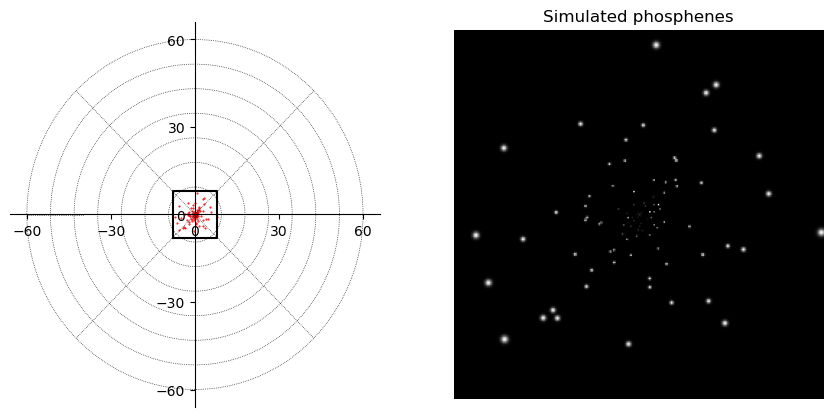

In [8]:
# Visualize
fig, axs = plt.subplots(1,2, figsize=(10.5,5))

# Plot the phosphene locations in the visual field
axs[0].plot(*phosphene_coords.cartesian, 'r.', markersize=1)
plot_fov(params, axs[0])

# Plot the simulated phosphene image
axs[1].imshow(phosphenes, cmap='gray', origin='lower') # (origin is lower left)
axs[1].axis('off')
axs[1].set_title('Simulated phosphenes')

## 2. Cortex models
Instead of specifying a list of phosphene locations directly, the simulator can be initialized with a list of electrode locations in the visual cortex. 

In [9]:
# Load the simulator configuration file
params = utils.load_params('params.yaml')

# Load electrode locations from a file (cartesian cortical flatmap coordinates)
x,y = utils.load_coordinates_from_yaml(os.path.join('grid_coords_squares_utah.yaml'))
coordinates_cortex = Map(x=x,y=y) # (<- The electrode locations can also be specified manually here)

# Map the cortex coordinates to visual field coordinates
phosphene_coords = cortex_models.get_visual_field_coordinates_from_cortex(params['cortex_model'], coordinates_cortex)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)
n_phosphenes = simulator.num_phosphenes

# Reset and call the simulator
stim = 80.e-6 * torch.ones(n_phosphenes).to('cuda') # (All electrodes are activated)
simulator.reset()
phosphenes = simulator(stim)

In [10]:
phosphenes = phosphenes.cpu().numpy()

Text(0.5, 1.0, 'Simulated phosphenes')

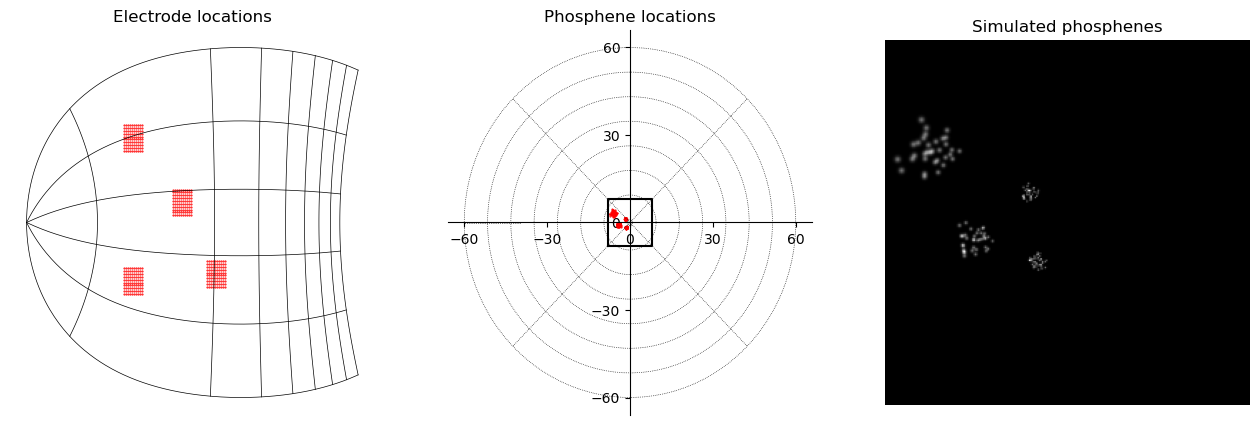

In [11]:
# Visualize
fig, axs = plt.subplots(1,3, figsize=(16,5))

# Plot the electrode locations on the cortical flatmap
axs[0].plot(*coordinates_cortex.cartesian, 'r.', markersize=1)
plot_cortex_flatmap(params,axs[0])
axs[0].set_title('Electrode locations')

# Plot the phosphene locations in the visual field
axs[1].plot(*phosphene_coords.cartesian, 'r.', markersize=1)
plot_fov(params, axs[1])
axs[1].set_title('Phosphene locations')

# Plot the simulated phosphene image
axs[2].imshow(phosphenes,cmap='gray', origin='lower') # (origin is lower left) 
axs[2].axis('off')
axs[2].set_title('Simulated phosphenes')

### 3. Stimulation parameters
Instead of providing only the stimulation amplitudes, the other stimulation parameters (pulse width, frequency) can also be specified for each electrode.

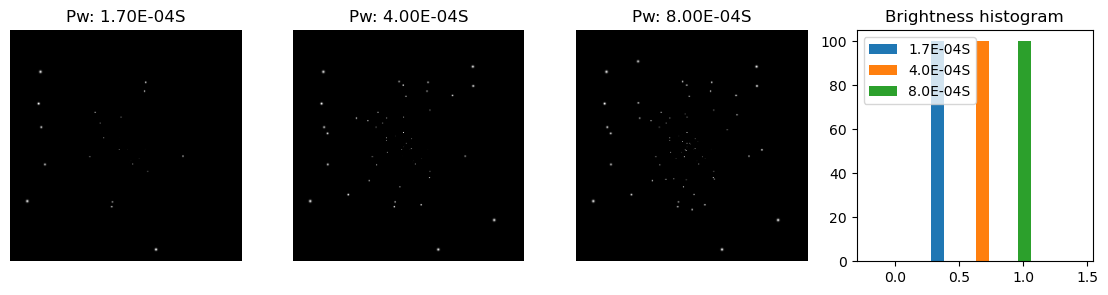

In [28]:
# Load the simulator configuration file
params = utils.load_params('params.yaml')
params['run']['fps'] = 10 # 10 fps -> a single frame represents 100 milliseconds

# Get phosphene coordinates and initialize simulator
n_phosphenes = 100
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = PhospheneSimulator(params, phosphene_coords)

# Plot phosphenes for different pulse widths
stim_amp = 35e-6 # A
freq = 300 # Hz
PWs = np.array([170.,400.,800.])*1e-6 # S

fig, axs = plt.subplots(1,4,figsize=(14,3))
for i,PW in enumerate(PWs):
    simulator.reset()
    stim = stim_amp*torch.ones(n_phosphenes).to('cuda')
    f = freq*torch.ones(n_phosphenes).to('cuda')
    pw = PW*torch.ones(n_phosphenes).to('cuda')
    img = simulator(stim,pw,f)
    img = img.cpu().numpy()
    axs[i].imshow(img,cmap='gray',origin='lower')
    axs[i].axis('off')
    axs[i].set_title(f'Pw: {PW:0.2E}S')

    # histogram of brightness
    axs[3].hist(to_numpy(simulator.brightness.get()).ravel(), label=f'{PW:0.1E}S')

axs[3].legend()
axs[3].set_title('Brightness histogram')
plt.show()

## 4. Image preprocessing
In many experimental simulation paradigms, input images are preprocessed and used to create simulated phosphene images. This can be achieved with our simulator in three steps:
- image processing: natural image -> simplified image (e.g., edge detection.)
- stimulus sampling: simplified image -> stimulation vector (e.g., specific pixels in the edge image are mapped to specific electrode activations.)
- phosphene simulation: stimulation vector -> simulated phosphene representation (as readily demonstrated in above examples)


#### Image processing - creating a simplified representation of the input image

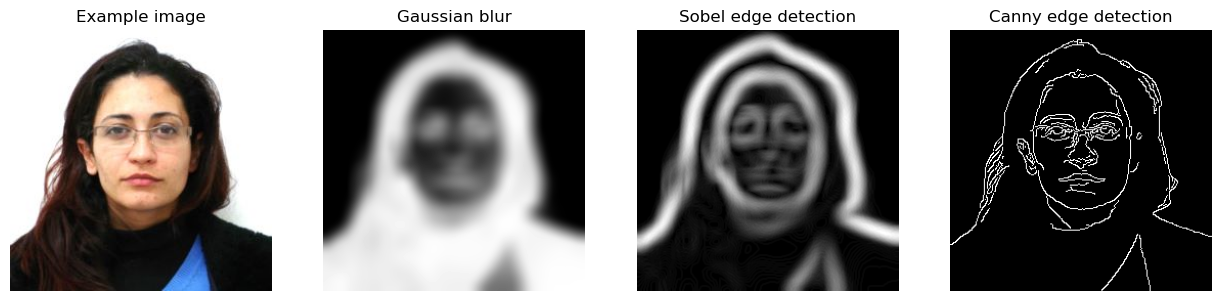

In [6]:
# Load the simulator configuration file
params = utils.load_params('params.yaml')
params['run']['fps'] = 10 # 10 fps -> a single frame represents 100 milliseconds

# Get phosphene coordinates and initialize simulator
n_phosphenes = 1000
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = PhospheneSimulator(params, phosphene_coords)

# Visualize different image processing examples
fig, axs = plt.subplots(1,4, figsize=(15.5,8))

# Example image
img = cv2.imread('37-11-256.jpg')
img = img[::-1] # Flip vertically (origin is lower-left)
axs[0].imshow(img[:,:,::-1], origin='lower') # (Invert color channels)
axs[0].set_title('Example image')

# General preprocessing
resolution = (256,256)
frame = cv2.resize(img, resolution)
img_gray = 255 - cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Gaussian blur
img_blur = cv2.GaussianBlur(img_gray, (21,21), 7)
axs[1].imshow(img_blur, cmap='gray', origin='lower')
axs[1].set_title('Gaussian blur')

# Sobel edge detection
img_sobel = sobel_processor(img_blur)
axs[2].imshow(img_sobel, cmap='gray', origin='lower')
axs[2].set_title('Sobel edge detection')

# Canny edge detection
img_canny = canny_processor(img,threshold_low=100,threshold_high=200)
axs[3].imshow(img_canny, cmap='gray', origin='lower')
axs[3].set_title('Canny edge detection')

for ax in axs.flatten():
    ax.axis('off')

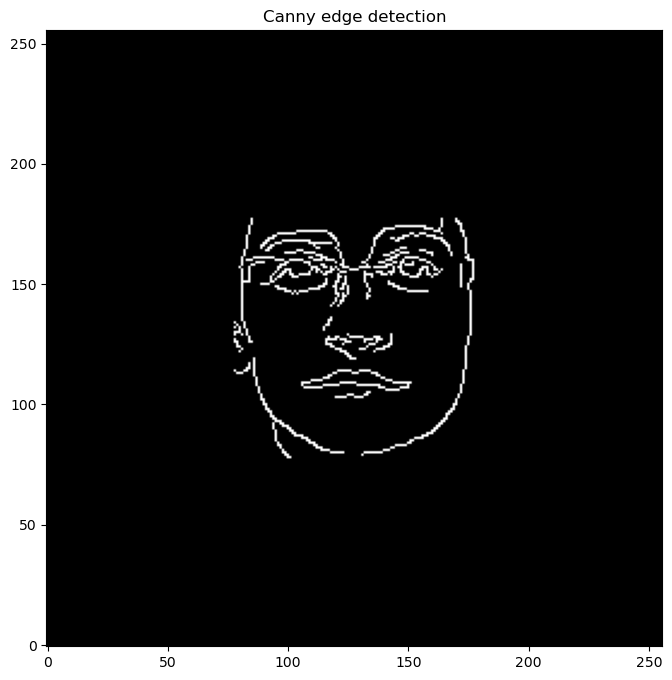

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread("37-11-256.jpg")
image = image[::-1]
# Get the dimensions of the image
height, width = image.shape[:2]

# Define the coordinates of the center region
center_x = width // 2
center_y = height // 2
region_size = 100

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection to the entire image
edges = cv2.Canny(gray_image, 120, 220)

# Create a mask for the center region
mask = np.zeros_like(edges)
mask[center_y - region_size//2: center_y + region_size//2, 
     center_x - region_size//2: center_x + region_size//2] = 255

# Apply the mask to the detected edges
img_canny = cv2.bitwise_and(edges, mask)

# Display the masked edges
fig, axs = plt.subplots(1,1, figsize=(15.5,8))
axs.imshow(img_canny, cmap='gray', origin='lower')  # Set origin as 'upper'
axs.set_title('Canny edge detection')
plt.show()



#### Stimulus sampling - mapping an image to stimulation vector
The inbuilt stimulus sampling method samples the pixel intensities at the phosphene locations to obtain a stimulation vector. By default, the pixel values of the sampled image are expected to represent the stimulation amplitude in Ampère. 

By setting the rescale argument to True, the stimulus sampling method can be explicitly instructed to remap the pixels values: [0., 1.] or [0, 255] -> [0.,
*stimulus_scale*]. The *stimulus_scale* is specified in the simulator configuration file (100 microampere by default).

In [22]:
##  Obtain the stimulation amplitudes by sampling the image at the phosphene locations. 
## The range of the pixel intensities needs to be mapped to the range of stimulation amplitudes.

# Simply set 'rescale=True', which maps pixels in range [0,255] to [0, 100e-6] by default.... 
stim_gray = simulator.sample_stimulus(img_gray, rescale=True) 
stim_blur = simulator.sample_stimulus(img_blur, rescale=True)

# ... or make sure that the pixel values represent the stimulation amplitudes for each region of the input image.
def normalized_rescaling(img, stimulus_scale=100.e-6):
    """Normalize <img> and rescale the pixel intensities in the range [0, <stimulus_scale>].
    The output image represents the stimulation intensity map.
    param stimulus_scale: the stimulation amplitude corresponding to the highest-valued pixel.
    return: image with rescaled pixel values (stimulation intensity map in Ampères)."""
    img_norm = (img-img.min())/(img.max()-img.min())
    return img_norm * stimulus_scale
sobel_rescaled = normalized_rescaling(img_sobel)
canny_rescaled = normalized_rescaling(img_canny)
stim_sobel = simulator.sample_stimulus(sobel_rescaled)
stim_canny = simulator.sample_stimulus(canny_rescaled)

# Print example comparison
print(f'Pixel intensities of the Canny edge detection img.\n'
      f'Before rescaling pixel values: min={img_canny.min()}, max={img_canny.max()}')
print(f'After rescaling pixel values: min={canny_rescaled.min()}, max={canny_rescaled.max()}')

Pixel intensities of the Canny edge detection img.
Before rescaling pixel values: min=0, max=255
After rescaling pixel values: min=0.0, max=0.0001


#### Simulated phosphene images

Text(0.5, 1.0, 'Canny edge detection')

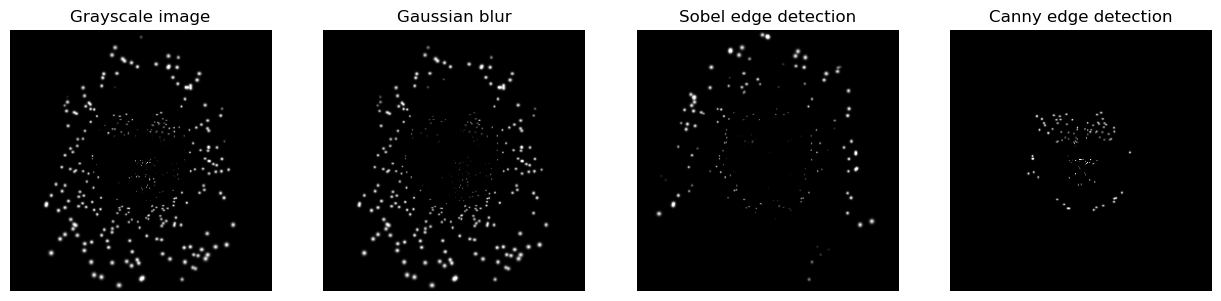

In [23]:
fig, axs = plt.subplots(1,4, figsize=(15.5,8))

# Parse each stimulation vector through the simulator 
for i, stim in enumerate([stim_gray, stim_blur, stim_sobel, stim_canny]):
    simulator.reset()    
    phosphenes=simulator(stim)
    phosphenes = phosphenes.cpu().numpy()
    axs[i].imshow(phosphenes, origin='lower', cmap='gray')

for ax in axs.flatten():
    ax.axis('off')

axs[0].set_title('Grayscale image')
axs[1].set_title('Gaussian blur')
axs[2].set_title('Sobel edge detection')
axs[3].set_title('Canny edge detection')

In [ ]:
plt.

##### Final note on the stimulus sampling method..
By default, the stim amplitude equals the intensity of the sampled image. So, when working with images with pixels in range [0, 255] or [0., 1.], rescaling the pixel values to [0., *stimulus_scale*] (e.g. [0., 100.e-6] Ampère) is an important step that cannot be omitted. Unlike earlier versions of the code, rescaling needs to be incorporated *explicitly*. (Automatic rescaling is no longer the default behaviour).

In [42]:
# Omitting the rescaling
stim = simulator.sample_stimulus(img_gray) # <- Not ok. This raises a warning because of the high pixel values.

# Using the inbuilt rescaling
stim = simulator.sample_stimulus(img_gray, rescale=True) # <- This is ok. 

# Provide pixels values in range [0., 100e-6]
activation_mask = (img_gray / 255) * 100.e-6
stim = simulator.sample_stimulus(activation_mask) # <- This is also ok. 

D:\Gebruiker_Gwendolyn\Gwendolyn\ipykernel_28324\272392570.py:2: DeprecationWarning: High values detected! Activation mask not longer rescaled as default behaviour. Please set rescale=True to map pixels in range [0, 1] or [0, 255] to the default stimulus scale.
  stim = simulator.sample_stimulus(img_gray) # <- Not ok. This raises a warning because of the high pixel values.


## 5. Example video

In [15]:
# Load the simulator configuration file
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates and initialize simulator
n_phosphenes = 1000
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = PhospheneSimulator(params, phosphene_coords)

# Stop after a couple of seconds
framerate = params['run']['fps']
max_n_frames = 2*framerate

# Load the videostream
cap = cv2.VideoCapture('./example_video.mp4')
if not cap.isOpened():
    print('Unable to read file :(')

# Set the output stream
fourcc = cv2.VideoWriter_fourcc(*'XVID') #codec
out = cv2.VideoWriter('clip_phosphenes.avi', fourcc, framerate, (512,256),False)

# Loop over frames
frame_nr = 0
while frame_nr<max_n_frames:
    # load next frame
    ret, frame = cap.read()
    frame_nr+=1
    
    if not ret:
        break 
        
    # to one channel, grayscale 
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # get square if frame is not square
    if frame.shape[0] != frame.shape[1]:
        shortest_side = min(frame.shape)
        frame = frame[frame.shape[0]//2-shortest_side//2:frame.shape[0]//2+shortest_side//2,
                      frame.shape[1]//2-shortest_side//2:frame.shape[1]//2+shortest_side//2]
        
    # preprocess: to resize, grayscale and blur
    frame = cv2.resize(frame, (256,256))
    frame = cv2.GaussianBlur(frame, (21,21), 5)

    # edge/contour detector
    processed_img = sobel_processor(frame)
    processed_img = frame
    stim_pattern = simulator.sample_stimulus(processed_img, rescale=True)

    # Generate phosphenes 
    phs = simulator(stim_pattern).clamp(0,1)
    phs = to_numpy(phs)*255

    # Concatenate results
    # cat = np.concatenate([frame, processed_img, phs], axis=1).astype('uint8')
    cat = np.concatenate([processed_img, phs], axis=1).astype('uint8')
    
    out.write(cat)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release() 

cv2.destroyAllWindows()

## 6. Internal parameters

In [58]:
# Load the simulator configuration file
params = utils.load_params('params.yaml')

# Get phosphene coordinates and initialize simulator
n_phosphenes = 5
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = PhospheneSimulator(params, phosphene_coords)

# One example frame with random stimulation
simulator.reset()
phosphenes = simulator(100e-6*torch.rand(n_phosphenes).to('cuda'))

#### Phosphene maps
The phosphene_maps indicate the distance in degrees of visual angle from the center of each phosphene.

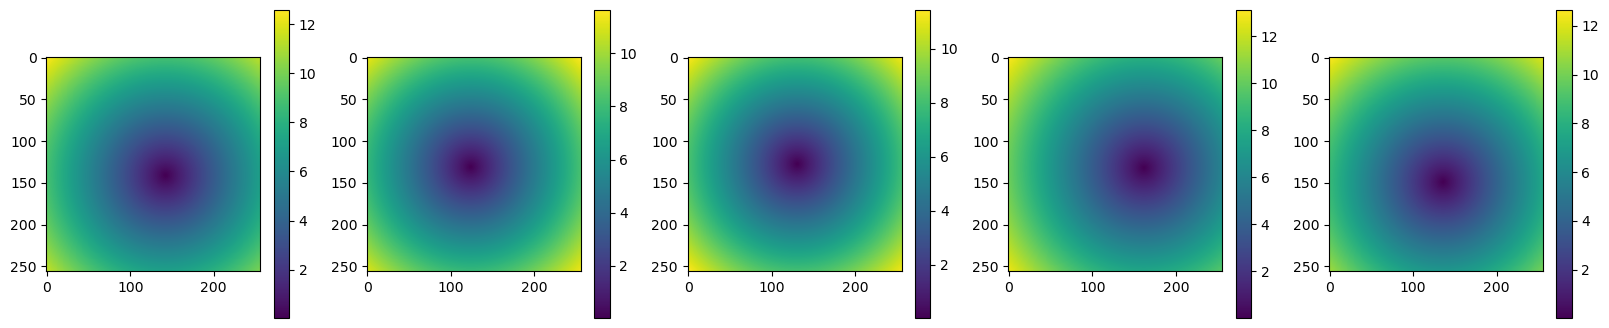

In [59]:
fig, axs= plt.subplots(1,5,figsize=(20,4))
for i, ax in enumerate(axs.flatten()):
    h = ax.imshow(simulator.phosphene_maps[i].cpu().numpy())
    fig.colorbar(h)

#### Internal states
Several of the simulators internal states can be accessed, such as the *threshold*, *activation*, *brightness* and *trace*.

In [60]:
# For instance, the perception thresholds for each phosphene can be accessed.. 
thresholds = simulator.threshold.get()
print(thresholds)

# ... and reinitialized manually.
simulator.threshold.reinitialize(torch.rand_like(thresholds)*1e-7)
thresholds = simulator.threshold.get()
print(thresholds)

tensor([[[1.9403e-08]],

        [[0.0000e+00]],

        [[7.1663e-08]],

        [[7.4800e-08]],

        [[1.3837e-07]]], device='cuda:0')
tensor([[[6.1296e-08]],

        [[1.0059e-09]],

        [[3.9841e-08]],

        [[4.0308e-09]],

        [[1.5627e-08]]], device='cuda:0')


D:\Anaconda\Lib\site-packages\dynaphos\utils.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, **data_kwargs)


In [61]:
# The internal states can be obtained at once using the get_state method
all_states = simulator.get_state() # get all internal parameters
print(all_states['brightness'])

tensor([[[0.4427]],

        [[0.4653]],

        [[0.1646]],

        [[0.4961]],

        [[0.1676]]], device='cuda:0')


## 7. Computational optimization
The simulation framework is created in pytorch and makes use of differentiable operations to enable computational optimization. 

Note: The code below is an extremely simplified 'mock example' of computational optimization of the stimulation parameters. It is *not* part of the the end-to-end optimization paradigm used in the experiments of the publication. That end-to-end optimization framework can be found in  [**this repository**](https://github.com/neuralcodinglab/viseon/tree/dynaphos-paper).

#### Mock example of computational optimization


In [75]:
# Load the simulator configuration file
params = utils.load_params('params.yaml')

# Get phosphene coordinates and initialize simulator
n_phosphenes = 5
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = PhospheneSimulator(params, phosphene_coords)

# Optimization target
target_brightness = 0.5 * torch.ones(simulator.shape).to('cuda')

# Initialize an 'encoder' which will be optimized 
# (note: not using a real DNN encoder here, but just a tensor that scales the stimulation)
base_stim = 100e-6 * torch.ones(n_phosphenes) 
encoder = torch.nn.Parameter(torch.rand(5), requires_grad=True)
optimizer = torch.optim.Adam([encoder],lr=0.05)
print(encoder)

Parameter containing:
tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904], requires_grad=True)


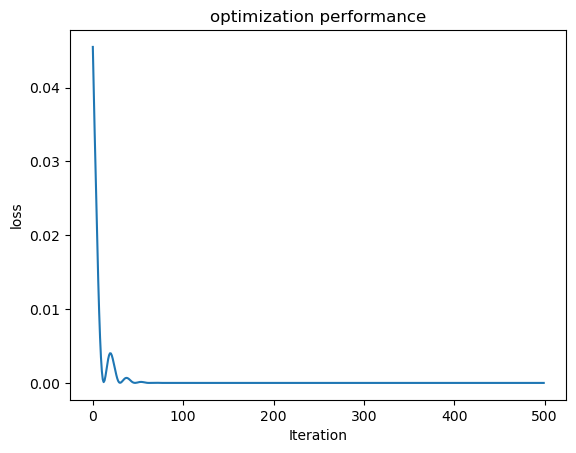

Parameter containing:
tensor([0.9648, 0.9648, 0.9648, 0.9648, 0.9648], requires_grad=True)


In [77]:
# Track optimization performance 
hist = {'brightness': [],
        'stim': [],
        'encoder': [],
        'loss': []}

# Iteratively update the 'encoder'
for _ in range(500):
    optimizer.zero_grad()
    simulator.reset()
    stim = base_stim * encoder
    phosphenes = simulator(stim.to('cuda'))
    brightness = simulator.get_state()['brightness']
    mse = torch.nn.functional.mse_loss(brightness, target_brightness)
    mse.backward()
    optimizer.step()

    # Track optimization performance
    hist['stim'].append(stim.detach().clone())
    hist['encoder'].append(encoder.detach().clone())
    hist['brightness'].append(brightness.detach().clone())
    hist['loss'].append(mse.item())

fig, ax = plt.subplots()
ax.plot(hist['loss'])
ax.set(xlabel='Iteration', ylabel='loss', title='optimization performance')
plt.show()

print(encoder)